02 SEP 2017

This is a continuation of `nueral_sr_attempt2.ipynb`

In [1]:
%matplotlib inline
import importlib

import os, sys; sys.path.insert(1, os.path.join('../utils'))

import utils2; importlib.reload(utils2)
from utils2 import *

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg

Using TensorFlow backend.
/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from bcolz_array_iterator import BcolzArrayIterator

In [3]:
limit_mem()

In [4]:
path = '../data/'
dpath = path

In [5]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [6]:
# resizing chunk length to 6

arr_lr = bcolz.open(path+'trn_resized_72.bc')
arr_hr = bcolz.open(path+'trn_resized_288.bc')

arr_lr_c6 = bcolz.carray(arr_lr, chunklen=6, rootdir=path+'trn_resized_72_c6.bc')
arr_lr_c6.flush()

arr_hr_c6 = bcolz.carray(arr_hr, chunklen=6, rootdir=path+'trn_resized_288_c6.bc')
arr_hr_c6.flush()

OSError: specified rootdir path '../data/trn_resized_72_c6.bc' already exists and creation mode is 'a'

In [6]:
arr_lr_c6 = bcolz.open(dpath+'trn_resized_72_c6.bc')
arr_hr_c6 = bcolz.open(path+'trn_resized_288_c6.bc')
parms = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

In [7]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x) if act else x
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return merge([x, ip], mode='sum')
def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Convolution2D(filters, size, size, border_mode='same')(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)
def get_model(arr):
    inp=Input(arr.shape[1:])
    x=conv_block(inp, 64, 9, (1,1))
    for i in range(4): x=res_block(x)
    x=up_block(x, 64, 3)
    x=up_block(x, 64, 3)
    x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
    outp=Lambda(lambda x: (x+1)*127.5)(x)
    return inp,outp

In [8]:
inp,outp=get_model(arr_lr_c6)

In [9]:
shp = arr_hr_c6.shape[1:]

vgg_inp=Input(shp)
vgg= VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))
for l in vgg.layers: l.trainable=False

In [10]:
def get_outp(m, ln): return m.get_layer(f'block{ln}_conv2').output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [1,2,3]])
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

In [11]:
def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

In [12]:
w=[0.1, 0.8, 0.1]
def content_fn(x): 
    res = 0; n=len(w)
    for i in range(n): res += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return res

In [13]:
m_sr = Model([inp, vgg_inp], Lambda(content_fn)(vgg1+vgg2))
m_sr.compile('adam', 'mae')

In [14]:
def train(bs, niter=10):
    targ = np.zeros((bs, 1))
    bc = BcolzArrayIterator(arr_hr_c6, arr_lr_c6, batch_size=bs)
#     for i in range(niter):
    for i in tqdm(range(niter)): # adding a progress bar so I know what's going on
        hr,lr = next(bc)
        m_sr.train_on_batch([lr[:bs], hr[:bs]], targ)

In [15]:
its = len(arr_hr_c6)//16; its

1214

In [16]:
arr_lr_c6.chunklen, arr_hr_c6.chunklen

(6, 6)

In [17]:
arr_lr_c6.shape, arr_hr_c6.shape

((19439, 72, 72, 3), (19439, 288, 288, 3))

In [20]:
# 19439//6 = 3239
%time train(6, 3240)

ValueError: Input arrays should have the same number of samples as target arrays. Found 5 input samples and 6 target samples.

In [18]:
%time train(6, 3239)

CPU times: user 38min 23s, sys: 28min 45s, total: 1h 7min 8s
Wall time: 1h 37min 6s


*Oh My Fucking God It Finally Worked.*

*2 Days? 3? Whatever.*

In [19]:
m_sr.save_weights(path+'m_sr_trainedv1.h5')

In [20]:
K.set_value(m_sr.optimizer.lr, 1e-4)
train(6, 3239)

In [21]:
m_sr.save_weights(path+'m_sr_trainedv2.h5')

In [22]:
top_model = Model(inp, outp)

In [23]:
p = top_model.predict(arr_lr_c6[:20])

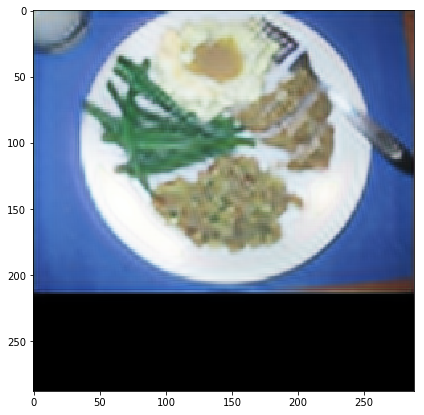

In [34]:
plt.figure(figsize=(7,7))
plt.imshow(p[0].astype('uint8'))

*It looks like I finally managed to upscale this damned breakfast. Eh.*

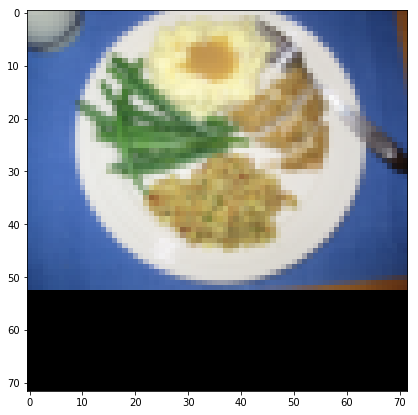

In [35]:
plt.figure(figsize=(7,7))
plt.imshow(arr_lr_c6[0].astype('uint8'))

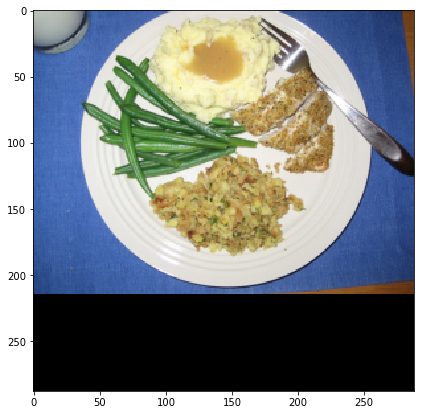

In [36]:
plt.figure(figsize=(7,7))
plt.imshow(arr_hr_c6[0].astype('uint8'))

In [ ]:
plt.imshow(p[1].astype('uint8'))

In [24]:
img_file = '../data/train/n01440764/n01440764_10365.JPEG'

In [25]:
img = Image.open(img_file).resize((288,288))

In [26]:
img_dat = np.expand_dims(np.array(img),0)

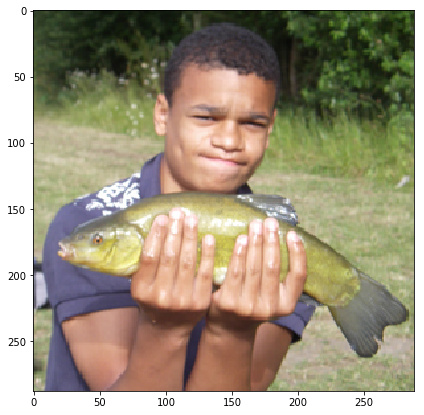

In [27]:
plt.figure(figsize=(7,7))
plt.imshow(img_dat[0]);

*I don't know what I'm supposed to do with this.*

Hi Res Original:

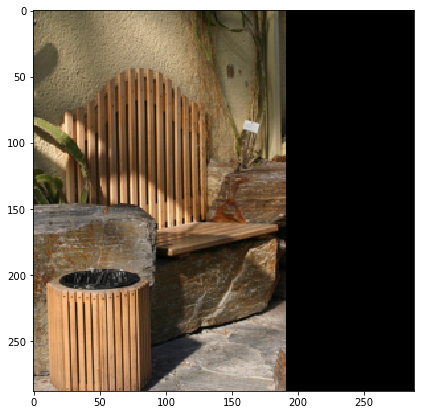

In [62]:
# idx = 19438
idx = 1100
plt.figure(figsize=(7,7))
plt.imshow(arr_hr_c6[idx].astype('uint8'))

In [46]:
len(arr_hr_c6)

19439

Super Res:

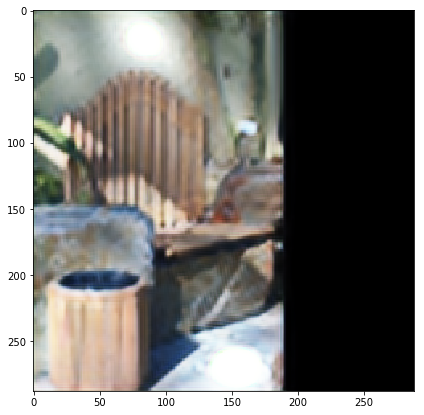

In [63]:
p = top_model.predict(arr_lr_c6[1100:1101])
plt.figure(figsize=(7,7))
plt.imshow(p[0].astype('uint8'))

Low res original:

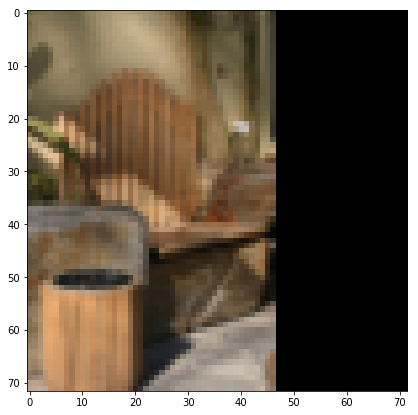

In [64]:
plt.figure(figsize=(7,7))
plt.imshow(arr_lr_c6[idx].astype('uint8'))

Super Res:

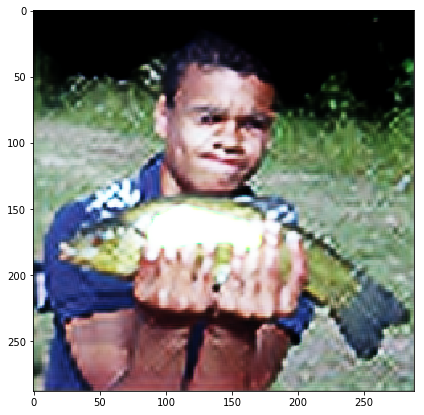

In [70]:
img = Image.open(img_file).resize((72,72))
img_dat = np.expand_dims(np.array(img),0)
p = top_model.predict(img_dat)
plt.figure(figsize=(7,7))
plt.imshow(p[0].astype('uint8'))

Original Low Res

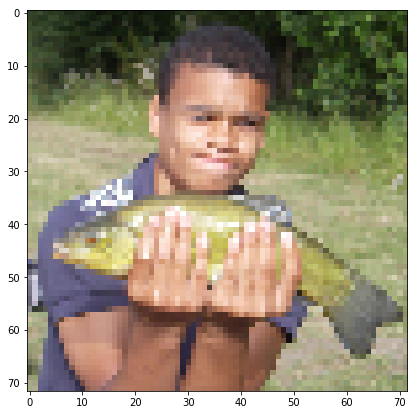

In [71]:
plt.figure(figsize=(7,7))
plt.imshow(img_dat[0])

Honestly, aside from the color and horrifying eyes, doesn't look like it did a bad job. It did only have ~19k examples to go on, whereas the class version I think had 900k.